# Week 11 - Neural Networks

Learning contents:
- Convolutional Neural Network
    - Implement the LeNet-5 inspired architecture in PyTorch
- Limited labelled data
    - Rerun the LeNet-5 network with only 100 examples total
- Implement an Autoencoder and train it on the unlabelled data
- Demo: Using the Autoencoder in a multi-task learning setup to improve classification performance.

In [3]:
# Imports you will need
import torch
from math import ceil
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim import SGD
from torch import tanh, flatten, relu
from torch.utils.data import DataLoader, random_split
from torch.nn import Conv2d, AvgPool2d, Linear, Module, ConvTranspose2d, Upsample, Tanh, Sequential
from torch.nn.functional import log_softmax, nll_loss, mse_loss

# Dataset
We'll be using the MNIST dataset again this time:

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('../data', train=False, download=True, transform=transform)

train_loader = DataLoader(
    train_data,
    batch_size = 64,
    shuffle=True,
)

test_loader = DataLoader(
    test_data,
    batch_size = 64,
)

In [5]:
data, targets = next(iter(train_loader))
data.shape, targets.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

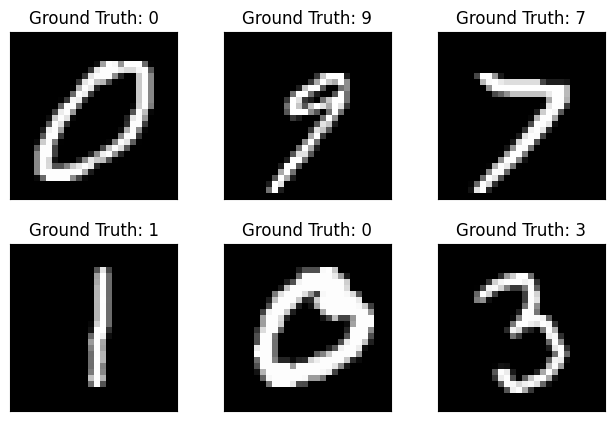

In [6]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(targets[i]))
    plt.xticks([])
    plt.yticks([])

## 1) Convolutional Neural Network
In this exercise, we will implement a Convolutional Neural Network inspired by the LeNet-5 architecture.

![](lenet.png)
Source: http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

Unlike the original architecture, for the subsampling we will use Averarge Pooling, and our output layer will be another Linear layer.

## 1.1) Implement the LeNet-5 inspired architecture in PyTorch
The architecture should consist of the following layers:
- Convolutional layer with  6 neurons, a 5x5 kernel, and stride 1, followed by a tanh function
- Average pooling layer with a 2x2 window size
- Convolutional layer with 16 neurons, a 5x5 kernel, and stride 1, followed by a tanh function
- Average pooling layer with a 2x2 window size
- Fully connected layer with 120 neurons
- Fully connected layer with 84 neurons

In [7]:
class LeNet5(Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        ### CODE HERE ###
        # Initialise the layers here. Use Conv2d, AvgPool2d, Linear, and Tanh
        self.conv1 = Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.pool1 = AvgPool2d(kernel_size=2, stride=2) # Window size 2 without no values checked for twice, due to stride. 
        Tanh()
        self.conv2 = Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride =1, padding=0)
        self.pool2 = AvgPool2d(kernel_size=2, stride=2)
        Tanh()
        self.fc1 = Linear(in_features=16*4*4, out_features=120)
        self.fc2 = Linear(in_features=120, out_features=84)
        self.fc3 = Linear(in_features=84, out_features=10)


    def forward(self, x):        
        def convAndPool(conv, pool, x): 
            # Convolution
            x = conv(x)
            x = tanh(x)

            # Pooling
            x = pool(x)
            return x
        
        ### CODE HERE ###
        # Propagate the data through the layers
        x = convAndPool(self.conv1, self.pool1, x) # 1st. Convolution (24x24), 1st. Pool (12x12)
        x = convAndPool(self.conv2, self.pool2, x) # 2nd. Convolution (8x8), 2nd. Pool (4x4)           
        
        x = flatten(x, 1)  # Flatten the tensor for the fully connected layers
        x = tanh(self.fc1(x))
        x = tanh(self.fc2(x))
        x = self.fc3(x)
        
        return log_softmax(x, dim=1)
    
    
def train(
    model:Module, 
    train_loader:DataLoader, 
    optimizer: SGD, 
    epoch:int, 
    log_interval = 50
):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Reset the gradients
        optimizer.zero_grad() 
        
        # Feed the data through the model
        output = model(data) 
        
        # Compute the negative log-likelihood loss
        loss = nll_loss(output, target) 
        
        # Backward propagate the gradients
        loss.backward() 
        
        # Perform an update step using the optimizer
        optimizer.step() 
        
        # Log
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model:Module, test_loader:DataLoader):
    # Set model to evaluation mode
    model.eval()
    
    test_loss = 0
    correct = 0
    
    # Don't accumulate gradients
    with torch.no_grad():
        for data, target in test_loader:
            # Feed the data through the model
            output = model(data)
            
            # Sum up batch loss
            test_loss += nll_loss(output, target, reduction='sum').item()  
            
            # The prediction is the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)  
            
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)
    ))

Train the network for 10 epochs using SGD with a `learning_rate = 0.01` and `momentum = 0.9`.
You should be able to get a 99% accuracy.

In [8]:
model = LeNet5()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

epochs = 10
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch, log_interval=50)
    test(model, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318494
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.966421
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.804653
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.497099
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.287163
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.298611
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.382785
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.278287
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.190291
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.348887
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.317319
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.244567
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.167304
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.047476
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.072848
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.065968
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.105669
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.075010
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.131260

Test set: Average loss: 0.1041, Accuracy: 9680/10000 (96.8

# 2) Limited labelled data
In the previous case, we had plenty of training data (60000 example) to get good performance.
What if we had much less data (100 examples)?

In [9]:
# Generate new datasets
mini_train_size = 100

mini_train_data, rest_train_data = random_split(  
    train_data, [mini_train_size, len(train_data) - mini_train_size]
)

# Our small labelled dataset
mini_train_loader = DataLoader(
    mini_train_data,
    batch_size = 64,
    shuffle=True,
)

# Our larger, unlabbeled dataset
# We will act as if we didn't have labels for this data
rest_train_loader = DataLoader(
    rest_train_data,
    batch_size = 64,
    shuffle=True,
)

## 2.1) Rerun the LeNet-5 network with only 100 examples total
Run it for 200 epochs using the `mini_train_loader`.
What is the test accuracy?

In [15]:
model = LeNet5()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

epochs = 200
for epoch in range(1, epochs + 1):
    train(model, mini_train_loader, optimizer, epoch)
    if epoch % 10 == 0:
        test(model, test_loader)

Train Epoch: 1 [0/100 (0%)]	Loss: 2.306569
Train Epoch: 2 [0/100 (0%)]	Loss: 2.284881
Train Epoch: 3 [0/100 (0%)]	Loss: 2.275458
Train Epoch: 4 [0/100 (0%)]	Loss: 2.274700
Train Epoch: 5 [0/100 (0%)]	Loss: 2.256717
Train Epoch: 6 [0/100 (0%)]	Loss: 2.257512
Train Epoch: 7 [0/100 (0%)]	Loss: 2.243068
Train Epoch: 8 [0/100 (0%)]	Loss: 2.213755
Train Epoch: 9 [0/100 (0%)]	Loss: 2.214697
Train Epoch: 10 [0/100 (0%)]	Loss: 2.203221

Test set: Average loss: 2.2436, Accuracy: 1659/10000 (16.590%)

Train Epoch: 11 [0/100 (0%)]	Loss: 2.168296
Train Epoch: 12 [0/100 (0%)]	Loss: 2.160325
Train Epoch: 13 [0/100 (0%)]	Loss: 2.136025
Train Epoch: 14 [0/100 (0%)]	Loss: 2.112020
Train Epoch: 15 [0/100 (0%)]	Loss: 2.103252
Train Epoch: 16 [0/100 (0%)]	Loss: 2.054732
Train Epoch: 17 [0/100 (0%)]	Loss: 2.038697
Train Epoch: 18 [0/100 (0%)]	Loss: 1.967684
Train Epoch: 19 [0/100 (0%)]	Loss: 1.956958
Train Epoch: 20 [0/100 (0%)]	Loss: 1.887000

Test set: Average loss: 1.9820, Accuracy: 3659/10000 (36.590%)


We end with ≈67% accuracy. NB: due to the small size of training data, the variance of the results may be high.

## 3) Implement an Autoencoder and train it on the unlabelled data
Though we have very little labelled training data, we may have plenty of unlabelled data available (`rest_data_loader`). 
This data can be utilised in many ways; one such way is by using an Autoencoder.

Implement an autoencoder with the following layers:
- Encoder:
    - Convolutional layer with  6 neurons, a 5x5 kernel, and stride 1, followed by a tanh function
    - Average pooling layer with a 2x2 window size
    - Convolutional layer with 16 neurons, a 5x5 kernel, and stride 1, followed by a tanh function
    - Average pooling layer with a 2x2 window size
    - Fully connected layer with 120 neurons
- Decoder:
    - Fully connected layer with 256 neurons
    - Upsample layer with scale-factor 2
    - Transpose convolution with 16 neurons, a 5x5 kernel, and stride 1, followed by a tanh function
    - Upsample layer with scale-factor 2
    - Transpose convolution with 6 neurons, a 5x5 kernel, and stride 1, followed by a tanh function
    
Use the given training code to train check that the implementation works and loss is reduced.

In [ ]:
class AutoEncoder(Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder_conv = Sequential(   
            # Initialise the convolutional and pooling layers here
            Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
            AvgPool2d(kernel_size=2, stride=2), # Window size 2 without no values checked for twice, due to stride. 
            Tanh(),
            Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride =1, padding=0),
            AvgPool2d(kernel_size=2, stride=2), 
            Tanh()
        )
        ### CODE HERE ###
        self.encoder_fc = Linear(in_features=16*4*4, out_features=120)
        self.decoder_fc = Linear(in_features=120, out_features= 256)
        self.decoder_conv = Sequential(     
            # Initialise the transpose convolutions and upsampling layers here
            Upsample(scale_factor=2),
            ConvTranspose2d(in_channels=16, out_channels=6, kernel_size=5, stride=1, padding=0),
            Tanh(),
            Upsample(scale_factor=2),
            ConvTranspose2d(in_channels=6, out_channels=1, kernel_size=5, stride=1, padding=0),
            Tanh()
 
        )

    def forward(self, x):
        # Propagate the data through the layers.
        # Hint: beware of the input and output shapes for each layer.
        # You will need to do call `reshape` along the way
        
        x = self.encoder_conv(x)
        
        # Flatten the output for the fully connected layers
        x = x.reshape(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])
        x = self.encoder_fc(x)
        
        x = self.decoder_fc(x)
        
        # Reshaping to expand the data 
        n = int(np.sqrt(x.shape[1]/(16))) # 256 -> (16 neurons, a, b) with a & b of same size 
        x = x.reshape(x.shape[0], 16, n, n) # 64 x 16 x 4 x 4
        x = self.decoder_conv(x)
        
        return x

def train_autoencoder(
    model:Module, 
    train_loader:DataLoader, 
    optimizer: SGD, 
    epoch:int, 
    log_interval = 50
):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        # Reset the gradients
        optimizer.zero_grad() 
        
        # Feed the data through the model
        output = model(data) 
        
        # Compute the negative log-likelihood loss
        loss = mse_loss(output, data) 
        
        # Backward propagate the gradients
        loss.backward() 
        
        # Perform an update step using the optimizer
        optimizer.step() 
        
        # Log
        if batch_idx % log_interval == 0:
            print('AE Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [12]:
# Check that the auto-encoder works by training it and checking that the loss is reduced
ae_model = AutoEncoder()
optimizer = SGD(ae_model.parameters(), lr=0.01, momentum=0.9)

batch_size = 64
epochs = 1
for epoch in range(1, epochs + 1):
    train_autoencoder(ae_model, rest_train_loader, optimizer, epoch, log_interval=50)

AE Train Epoch: 1 [0/59900 (0%)]	Loss: 1.089312
AE Train Epoch: 1 [3200/59900 (5%)]	Loss: 0.620064
AE Train Epoch: 1 [6400/59900 (11%)]	Loss: 0.581214
AE Train Epoch: 1 [9600/59900 (16%)]	Loss: 0.533426
AE Train Epoch: 1 [12800/59900 (21%)]	Loss: 0.516193
AE Train Epoch: 1 [16000/59900 (27%)]	Loss: 0.514223
AE Train Epoch: 1 [19200/59900 (32%)]	Loss: 0.500853
AE Train Epoch: 1 [22400/59900 (37%)]	Loss: 0.479252
AE Train Epoch: 1 [25600/59900 (43%)]	Loss: 0.486260
AE Train Epoch: 1 [28800/59900 (48%)]	Loss: 0.521809
AE Train Epoch: 1 [32000/59900 (53%)]	Loss: 0.478947
AE Train Epoch: 1 [35200/59900 (59%)]	Loss: 0.450146
AE Train Epoch: 1 [38400/59900 (64%)]	Loss: 0.463557
AE Train Epoch: 1 [41600/59900 (69%)]	Loss: 0.441452
AE Train Epoch: 1 [44800/59900 (75%)]	Loss: 0.440894
AE Train Epoch: 1 [48000/59900 (80%)]	Loss: 0.447411
AE Train Epoch: 1 [51200/59900 (85%)]	Loss: 0.418747
AE Train Epoch: 1 [54400/59900 (91%)]	Loss: 0.418232
AE Train Epoch: 1 [57600/59900 (96%)]	Loss: 0.449310


## Demo: Using the Autoencoder in a multi-task learning setup to improve classification performance.
Multitask learning is the learning of multiple tasks in parallel.
What we do here is to integrate the encoding layers of the autoencoder as layers in the LeNet5. We can then train the autoencoder and classification network in parallel in order to improve performance on the classification task.

The code below assumes that you have a working implementation of the Autoencoder.

In [13]:
class AutoEncoderLeNet5(Module):
    def __init__(self, autoencoder):
        super(AutoEncoderLeNet5, self).__init__()
        self.autoencoder = autoencoder
        self.fc2 = Linear(in_features=120, out_features=84)
        self.fc3 = Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.autoencoder.encoder_conv(x)
        x = flatten(x, 1)
        x = self.autoencoder.encoder_fc(x)
        x = tanh(self.fc2(x))
        x = tanh(self.fc3(x))
        return log_softmax(x, dim=1)
    
def train_hybrid(
    model:Module, 
    ae_model:Module,
    labelled_loader:DataLoader,
    unlabelled_loader:DataLoader,
    optimizer: SGD, 
    labelled_steps:int,
    unlabelled_steps:int,
    epoch:int, 
    log_interval = 50
):
    ae_model.train()
    model.train()
    labelled_iter = iter(labelled_loader)
    unlabelled_iter = iter(unlabelled_loader)
    for step in range(1, unlabelled_steps+1):
        if step % labelled_steps == 0:
            labelled_iter = iter(labelled_loader)
            
        data_l, target = next(labelled_iter)
        data_u, _ = next(unlabelled_iter)
        
        # Reset the gradients
        optimizer.zero_grad() 
        
        # Feed the data through the model
        output_u = ae_model(data_u)
        output_l = model(data_l)
        
        # Compute the negative log-likelihood loss
        loss_l = nll_loss(output_l, target) 
        loss_u = mse_loss(output_u, data_u) 
        
        # Backward propagate the gradients
        loss_u.backward() 
        loss_l.backward() 
        
        # Perform an update step using the optimizer
        optimizer.step() 
        
        # Log
        if step % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tULoss: {:.6f} \t LLoss: {:.6f}'.format(
                epoch, step * unlabelled_steps, len(unlabelled_loader.dataset),
                100. * step / unlabelled_steps, loss_u.item(), loss_l.item()))

In [16]:
ae_model = AutoEncoder()
hybrid_model = AutoEncoderLeNet5(ae_model)
optimizer = SGD(ae_model.parameters(), lr=0.01, momentum=0.9)

batch_size = 64
labelled_steps = ceil(len(mini_train_data) / batch_size)
unlabelled_steps = ceil(len(rest_train_data) / batch_size)
epochs = 5
for epoch in range(1, epochs + 1):
    train_hybrid(hybrid_model, ae_model, mini_train_loader, rest_train_loader, optimizer, labelled_steps, unlabelled_steps, epoch, log_interval=50)
    test(hybrid_model, test_loader)

Train Epoch: 1 [46800/59900 (5%)]	ULoss: 0.638788 	 LLoss: 1.946857
Train Epoch: 1 [93600/59900 (11%)]	ULoss: 0.567425 	 LLoss: 1.661371
Train Epoch: 1 [140400/59900 (16%)]	ULoss: 0.506849 	 LLoss: 1.499219
Train Epoch: 1 [187200/59900 (21%)]	ULoss: 0.523381 	 LLoss: 1.446247
Train Epoch: 1 [234000/59900 (27%)]	ULoss: 0.507366 	 LLoss: 1.376946
Train Epoch: 1 [280800/59900 (32%)]	ULoss: 0.492967 	 LLoss: 1.311337
Train Epoch: 1 [327600/59900 (37%)]	ULoss: 0.497315 	 LLoss: 1.278020
Train Epoch: 1 [374400/59900 (43%)]	ULoss: 0.490664 	 LLoss: 1.273170
Train Epoch: 1 [421200/59900 (48%)]	ULoss: 0.469947 	 LLoss: 1.252887
Train Epoch: 1 [468000/59900 (53%)]	ULoss: 0.452756 	 LLoss: 1.223834
Train Epoch: 1 [514800/59900 (59%)]	ULoss: 0.484968 	 LLoss: 1.208297
Train Epoch: 1 [561600/59900 (64%)]	ULoss: 0.471107 	 LLoss: 1.202373
Train Epoch: 1 [608400/59900 (69%)]	ULoss: 0.481512 	 LLoss: 1.163551
Train Epoch: 1 [655200/59900 (75%)]	ULoss: 0.454854 	 LLoss: 1.147028
Train Epoch: 1 [702000/

You should expect an classification accuracy boost of 10-15% compared to using only the `mini_train_loader`.